In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image

# from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.metrics import BinaryIoU


## models to import
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

2024-07-01 17:26:35.503083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 17:26:35.503202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 17:26:35.634584: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
!pip install --upgrade tensorflow 

In [ ]:
!pip install keras==3.2.1



In [ ]:
import keras
import tensorflow as tf

print(f"Keras version: {keras.__version__}")
print(f"TensorFlow version: {tf.__version__}")

In [2]:

# Directories
train_img_dir = r"/kaggle/input/fives-new-data/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Original/"
train_mask_dir = r"/kaggle/input/fives-new-data/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Ground truth/"
test_img_dir = r"/kaggle/input/fives-new-data/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Original/"
test_mask_dir = r"/kaggle/input/fives-new-data/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Ground truth/"

# Get the list of file names for images and masks
image_files = sorted([f for f in os.listdir(train_img_dir) if "Thumbs.db" not in f])
mask_files = sorted(os.listdir(train_mask_dir))

# Create a DataFrame
train = pd.DataFrame({'file_name': image_files, 'mask_name': mask_files})

image_files = sorted(os.listdir(test_img_dir))
mask_files = sorted(os.listdir(test_mask_dir))

# Create a DataFrame
test = pd.DataFrame({'file_name': image_files, 'mask_name': mask_files})

target_size = (512, 512)

################################
def apply_clahe(image):
    """Applies CLAHE to an image for contrast enhancement using OpenCV."""
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=6)
    enhanced_image = clahe.apply(gray_image)
    enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2BGR)
    return enhanced_image

def brightness_enhancment(image):
    brightness_image = cv2.convertScaleAbs(image, alpha=1.3, beta=20)
    return brightness_image

def gamma_correction(image):
    gamma = 1.2
    lookup_table = np.array([((i / 255.0) ** gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    gamma_corrected_image = cv2.LUT(image, lookup_table)
    return gamma_corrected_image

#####################################

def read_image_and_mask(file_name, mask_name, img_dir, mask_dir, target_size=target_size):
    image = Image.open(os.path.join(img_dir, file_name))
    image = image.resize(target_size)
    image = apply_clahe(image)
    image = brightness_enhancment(image)
    image = gamma_correction(image)
    image_array = np.array(image, dtype=np.uint8)  # Ensure uint8 dtype
#     image_array = image_array / 255.0  # Normalize to [0, 1]

    mask = Image.open(os.path.join(mask_dir, mask_name))
    mask = mask.resize(target_size, resample=Image.LANCZOS)
    mask_array = np.array(mask, dtype=np.uint8)
    mask_array = cv2.cvtColor(mask_array, cv2.COLOR_BGR2GRAY)
    mask_array = (mask_array > 0).astype(np.uint8)  # Binary mask
    mask_array = np.expand_dims(mask_array, axis=-1)  # Add channel dimension

    return image_array, mask_array

train_images = []
train_masks = []
for idx, row in train.iterrows():
    image, mask = read_image_and_mask(row['file_name'], row['mask_name'], train_img_dir, train_mask_dir)
    train_images.append(image)
    train_masks.append(mask)

train_images = np.array(train_images)
train_masks = np.array(train_masks)

test_images = []
test_masks = []
for idx, row in test.iterrows():
    image, mask = read_image_and_mask(row['file_name'], row['mask_name'], test_img_dir, test_mask_dir)
    test_images.append(image)
    test_masks.append(mask)

test_images = np.array(test_images)
test_masks = np.array(test_masks)

In [3]:
print("train images", train_images.shape,"---train masks",train_masks.shape )

print("train images", test_images.shape,"---train masks", test_masks.shape)

train images (600, 512, 512, 3) ---train masks (600, 512, 512, 1)
train images (200, 512, 512, 3) ---train masks (200, 512, 512, 1)


In [4]:
def show_image_with_mask(image, mask, title="Image and Mask, After"):
    """Displays an image and its corresponding mask side-by-side."""
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(122)
    plt.imshow(mask, cmap="gray")  # Use grayscale for masks
    plt.title("Mask")
    plt.axis("off")

    plt.suptitle(title)
    plt.show()

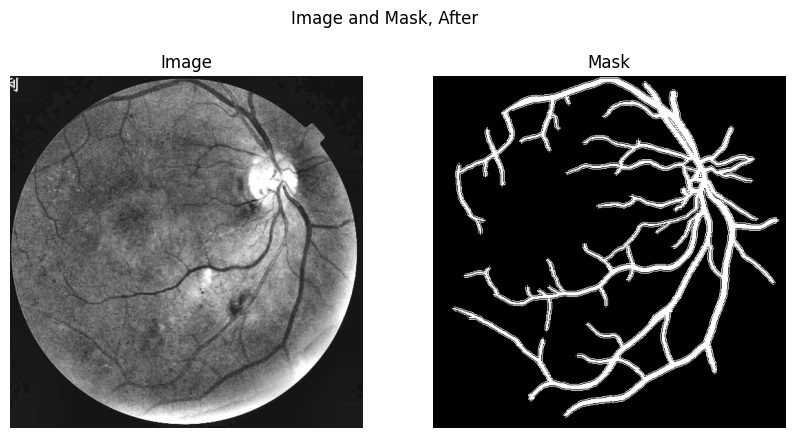

In [5]:
image = train_images[99]
mask = train_masks[99]

# Display the image and mask
show_image_with_mask(image, mask)

In [ ]:
def apply_clahe(image):
    """Applies CLAHE to an image for contrast enhancement using OpenCV."""
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=6)
    enhanced_image = clahe.apply(gray_image)
    enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2BGR)
    return enhanced_image

def brightness_enhancment(image):
    brightness_image = cv2.convertScaleAbs(image, alpha=1.2, beta=20)
    return brightness_image

def gamma_correction(image):
    gamma = 2
    lookup_table = np.array([((i / 255.0) ** gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    gamma_corrected_image = cv2.LUT(image, lookup_table)
    return gamma_corrected_image


In [ ]:
image = Image.open("/kaggle/input/fives-new-data/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Original/100_D.png")
image = image.resize((512,512))
image = apply_clahe(image)
image = brightness_enhancment(image)
image = gamma_correction(image)
image = np.array(image, dtype=np.uint8)
    
mask = Image.open("/kaggle/input/fives-new-data/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Ground truth/100_D.png")
mask = mask.resize((512,512), resample=Image.LANCZOS)
mask = np.array(mask, dtype=np.uint8)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = (mask > 0).astype(np.uint8)  # Binary mask
mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

show_image_with_mask(image, mask)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)


In [9]:
print("train images", len(X_train), X_train.dtype,":", "---train masks",len(y_train),":", y_train.dtype )

print("Validation images", len(X_val),  X_val.dtype, ":", "---Validation masks", len(y_val),":", y_val.dtype )

train images 480 uint8 : ---train masks 480 : uint8
Validation images 120 uint8 : ---Validation masks 120 : uint8


In [10]:
import albumentations as A

# Define data augmentation pipeline for training data
train_transform = A.Compose([
    A.HorizontalFlip(p=1),  # Flips images horizontally with 50% probability
    A.RandomBrightnessContrast(p=1.0), # Randomly adjusts brightness and contrast
    A.RandomGamma(p=1.0),  # Randomly adjusts gamma correction
    A.CoarseDropout(p=1, max_holes=10, max_height=32, max_width=32)
#     A.ElasticTransform(alpha=120, sigma=120, alpha_affine=120, p=0.2),  # Elastic deformation
#     A.RandomCrop(width=target_size[0], height=target_size[1], always_apply=True),  # Ensures consistent size
#     A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # Normalizes pixel values
])

In [11]:
augmented_images = []
augmented_masks = []
n_augmentations=4
for image, mask in zip(X_train, y_train):
    augmented_images.append(image)
    augmented_masks.append(mask)
    # Apply augmentation to both image and mask (can repeat for multiple augmentations per image)
    for _ in range(n_augmentations):  # Adjust n_augmentations for desired number of variations
        augmented = train_transform(image=image.copy(), mask=mask.copy())  # Copy image and mask to avoid modifying originals
        #i have a dictionary with two keys and two different values
        augmented_image = augmented["image"]
        augmented_mask = augmented["mask"]
        augmented_images.append(augmented_image)
        augmented_masks.append(augmented_mask)

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

In [12]:
print("the size of train images ->",len(augmented_images),"the size of train masks ->",len(augmented_masks))
print("the size of valid images ->",len(X_val),"the size of valid masks ->",len(y_val))
print("the size of test images ->",len(test_images),"the size of valid masks ->",len(test_masks))

the size of train images -> 2400 the size of train masks -> 2400
the size of valid images -> 120 the size of valid masks -> 120
the size of test images -> 200 the size of valid masks -> 200


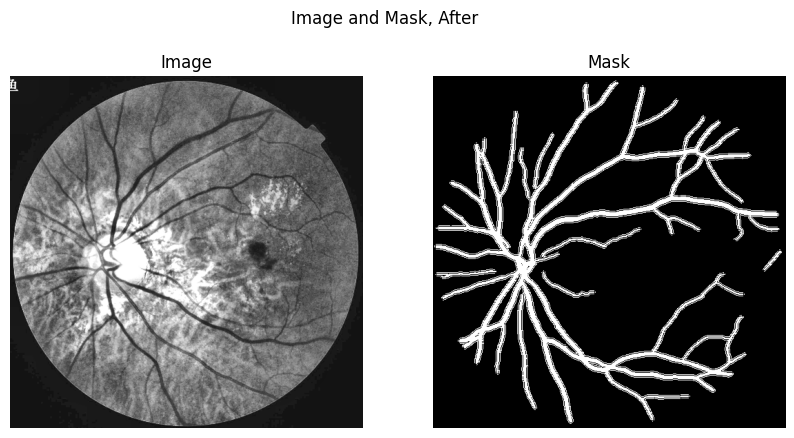

In [41]:
image = train_images[38]
mask = train_masks[10]

# Display the image and mask
show_image_with_mask(image, mask)

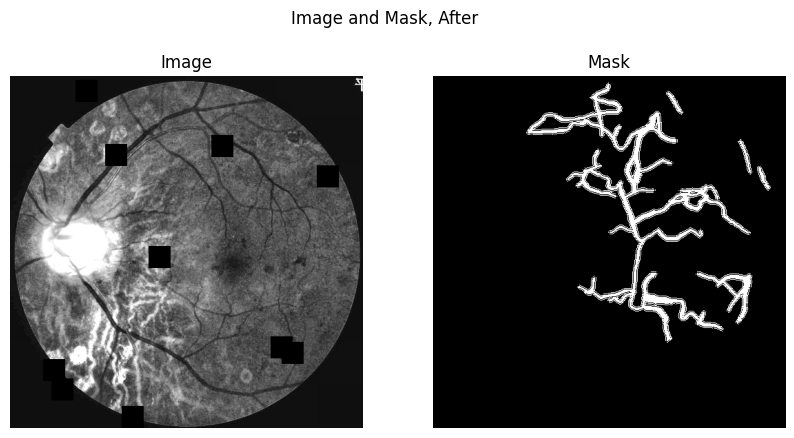

In [34]:
image = augmented_images[111]
mask = augmented_masks[1]

# Display the image and mask
show_image_with_mask(image, mask)

In [ ]:
class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, train_images, train_masks, epoch_interval=5):
        """
        Initialize the callback with separate train_images and train_masks arrays.

        Args:
            train_images (np.ndarray): Array containing training images.
            train_masks (np.ndarray): Array containing training masks.
            epoch_interval (int, optional): The number of epochs between visualizations (default: 5).
        """
        self.train_images = train_images
        self.train_masks = train_masks
        self.epoch_interval = epoch_interval

    def display(self, display_list, extra_title=''):
        """
        Displays a grid of images with titles.

        Args:
            display_list (list): A list of images to display.
            extra_title (str, optional): An additional title to display (default: '').
        """
        plt.figure(figsize=(15, 15))  # Adjust figure size as needed
        title = ['Input Image', 'True Mask', 'Predicted Mask']

        if len(display_list) > len(title):
            title.append(extra_title)

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i], cmap='gray')  # Adjust cmap if necessary
            plt.axis('off')
        plt.show()

    def create_mask(self, pred_mask):
        """
        Threshold and convert predicted mask to a binary array.

        Args:
            pred_mask (np.ndarray): The predicted mask from the model.

        Returns:
            np.ndarray: The thresholded and converted binary mask.
        """
        pred_mask = (pred_mask > 0.5).astype("int32")  # Threshold at 0.5 (adjust if needed)
        return pred_mask[0]  # Assuming the first element is the mask

    def show_predictions(self, num=1):
        """
        Shows predictions on a sample of images and masks from the training data.

        Args:
            num (int, optional): The number of samples to display (default: 1).
        """
        # Select random indices for samples
        sample_indices = np.random.choice(self.train_images.shape[0], size=num, replace=False)
        sample_images = self.train_images[sample_indices]
        sample_masks = self.train_masks[sample_indices]

        for image, mask in zip(sample_images, sample_masks):
            pred_mask = self.model.predict(np.expand_dims(image, axis=0))  # Add batch dimension
            self.display([image, mask, self.create_mask(pred_mask)])

    def on_epoch_end(self, epoch, logs=None):
        """
        Called at the end of each epoch. Prints a message and displays predictions if necessary.

        Args:
            epoch (int): The current epoch number.
            logs (dict, optional): Training logs (default: None).
        """
        if epoch and epoch % self.epoch_interval == 0:
            self.show_predictions()
            print('\nSample Prediction after epoch {}\n'.format(epoch+1))

checkpoint = ModelCheckpoint("FIVES_model_ck2.keras",
                 monitor='val_IoU',
                 verbose=1,
                 save_best_only=True,
                 save_weights_only=False,
                 mode='max',
                 save_freq='epoch')

early = EarlyStopping(monitor='val_loss',
          min_delta=0,
          patience=10,
          verbose=1,
          mode='max')

lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.5,
                                 patience=6,
                                 min_lr=.00001,
                                 verbose=1)


In [ ]:
!pip install segmentation_models

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

In [ ]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

# Input shape for 224x224 images
input_shape_224 = (512,512, 3)

model = Unet(input_shape_224)
model.summary()

In [ ]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
BACKBONE   = 'efficientnetb0'
n_classes  = 1 
activation = 'sigmoid' 
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
model.summary()

In [ ]:
# define optomizer
optim = keras.optimizers.SGD(0.0001)
bce   = keras.losses.BinaryCrossentropy()
metrics = [BinaryIoU(name='IoU')]
epochs=25

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, bce, metrics= metrics )

history= model.fit(augmented_images,
          augmented_masks,
          epochs=epochs,
          validation_data=(X_val, y_val),
#           validation_split=0.2,
          batch_size=4,
#           workers=5,
#           use_multiprocessing=True,
          callbacks=[DisplayCallback(X_val,y_val), lr_scheduler, checkpoint, early]
)

In [ ]:
from tensorflow.keras import backend as K

# # Clear previous models from memory
# K.clear_session()
# tf.compat.v1.reset_default_graph()

# BACKBONE   = 'efficientnetb0'
# # n_classes  = 1 
# # activation = 'sigmoid' 


# # Define the model with various transfer learning arguments
# model = sm.Unet(
#     backbone_name=BACKBONE, 
#     classes=1, 
#     activation='sigmoid', 
#     encoder_weights='imagenet', 
#     encoder_freeze=True, 
# #     decoder_filters=(64, 128, 256, 512, 1024),
# #     encoder_depth=5
# )

# Compile the model
model.compile(optimizer=Adam(learning_rate=.01), loss='binary_crossentropy', metrics=[BinaryIoU(name='IoU')])

# Train the model
history = model.fit(augmented_images, augmented_masks,
                    epochs=5,
                    validation_data=(X_val, y_val),
                    batch_size=8,
                    callbacks=[DisplayCallback(X_val,y_val),checkpoint,early,lr_scheduler])

# Unfreeze the encoder layers for fine-tuning
for layer in model.layers:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=.001), loss='binary_crossentropy', metrics=[BinaryIoU(name='IoU')])

# Continue training the model
history_fine_tune = model.fit(augmented_images, augmented_masks,
                                epochs=15,
                                batch_size=8,
                                validation_data=(X_val, y_val),
                                callbacks=[DisplayCallback(X_val,y_val),checkpoint,early,lr_scheduler])

In [ ]:
# Save the entire model
model.save("/kaggle/working/FIVES_model_test_IoU_0.85444.keras")

In [ ]:
plt.plot(history_fine_tune.history["IoU"])
plt.plot(history_fine_tune.history['val_IoU'])
plt.title("Model IoU")
plt.ylabel("IoU")
plt.xlabel("Epoch")
plt.legend(["IoU","Validation IoU"])
plt.show()

plt.plot(history_fine_tune.history['loss'])
plt.plot(history_fine_tune.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

In [ ]:
#Evaluating a segmentation model according to acc, loss is Wrong
model.evaluate(x=test_images,y=test_masks)


In [ ]:
pred = model.predict(test_images)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


threshold = 0.6  # You can adjust this threshold based on your needs

pred_binary = (pred > threshold).astype(np.uint8)  # Convert to binary (0/1)
# Now calculate the confusion matrix using pred_binary
cm = confusion_matrix(test_masks.flatten(), pred_binary.flatten())


# Print the confusion matrix in a clear format
print("Confusion Matrix:")
print(cm)

# Calculate true negatives (tn), false positives (fp), and other metrics (optional)
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]  # False negatives (for completeness)
tp = cm[1, 1]  # True positives (for completeness)

# Calculate additional metrics (e.g., precision, recall, F1-score)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity=tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
cr=classification_report(test_masks.flatten(), pred_binary.flatten())

print("\nMetrics:")
print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)  # Added for completeness
print("True Positives (TP):", tp)  # Added for completeness
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)
print("specificity:", specificity)
print("accuracy:", accuracy)
print( cr)

In [ ]:
# Define the number of images to visualize
num_images = 8

# Create a figure and axes for subplots
plt.figure(figsize=(15, 5*num_images))

# Loop through each image
for i in range(num_images):
    # Plot the original image on the left
    plt.subplot(num_images, 3, i*3 + 1)
    plt.imshow(test_images[i])
    plt.title('Image: ' + test['file_name'].iloc[i])
    plt.axis('off')

    # Plot the predicted mask in the middle
    plt.subplot(num_images, 3, i*3 + 2)
    plt.imshow(pred[i], cmap='gray')  # Assuming predicted masks are grayscale
    plt.title('Predicted Mask: ' + test['file_name'].iloc[i])
    plt.axis('off')

    # Plot the ground truth mask on the right
    plt.subplot(num_images, 3, i*3 + 3)
    plt.imshow(test_masks[i], cmap='gray')  # Assuming ground truth masks are grayscale
    plt.title('Ground Truth Mask: ' + test['mask_name'].iloc[i])
    plt.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()